In [45]:
import numpy as np
import pandas as pd
import geopandas as gpd
import urllib
import pylab as pl
import fiona
%pylab inline
from fiona.crs import from_epsg
import shapely
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Populating the interactive namespace from numpy and matplotlib


In [46]:
sf_df = pd.read_csv('./sf3.csv')

In [47]:
sf_df.shape

(9338, 14)

In [48]:
sf_df.head()

,street_name,NUMBER OF PERSONS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,peds_safety_sig,postvz_sl,shape_leng,new_humps,lt_calm
0,NaN,8.0,0,0.0,3,1,0,4,0,0.0,0.0,333.938333,0.0,0.0
1,1 278 robert f kennedy bridge n/,0.0,0,0.0,0,0,0,0,0,0.0,0.0,333.938333,0.0,0.0
2,1 900 g robert f kennedy bridge,0.0,0,0.0,0,0,0,0,0,0.0,0.0,333.938333,0.0,0.0
3,1 ave,0.0,0,0.0,0,0,0,0,0,0.0,0.0,333.938333,0.0,0.0
4,1 avenue,944.0,2,3.0,271,188,1,486,0,79.0,25.0,163.472673,0.0,0.0


In [49]:
sf_df['incidents'] = sf_df['NUMBER OF PERSONS INJURED'] + sf_df['NUMBER OF PERSONS KILLED']

In [50]:
sf_df.columns

Index(['street_name', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'peds_safety_sig', 'postvz_sl',
       'shape_leng', 'new_humps', 'lt_calm', 'incidents'],
      dtype='object')

In [98]:
df = sf_df[['peds_safety_sig', 'postvz_sl',
       'shape_leng', 'new_humps', 'lt_calm', 'incidents']]



In [158]:
rf_param = df[['peds_safety_sig', 'postvz_sl',
       'shape_leng', 'new_humps', 'lt_calm']]
rf_pred = df[['incidents']]

In [159]:
rf_param_train , rf_param_test , rf_pred_train,rf_pred_test = train_test_split(np.array(rf_param) , np.array(rf_pred) , random_state =1,test_size=0.8)

In [160]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [161]:
rf.fit(rf_param_train, rf_pred_train)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [162]:
rf_prediction = rf.predict(rf_param_test)

In [163]:
errors = abs(rf_prediction.reshape(rf_prediction.shape[0],1) - rf_pred_test)

In [164]:
rf_prediction

array([ 134.618     ,    6.16334441,    6.16334441, ...,    0.24934655,
          6.16334441,    6.16334441])

In [165]:
rf.score(rf_param_test, rf_pred_test)

0.34766272135872245

In [166]:
feature_importance_scores = rf.feature_importances_

In [167]:
features = ['pedestrian safety signas', 'post VZ speed limits',
       'speed hump length', 'number of new humps', 'left turn calming measures']
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, feature_importance_scores)]

In [168]:
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [177]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    
    importances = rf.feature_importances_
    
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    
    

    print(std)
    pl.figure(figsize=(8,8))
    pl.title("Feature importances" ,fontsize=14.0)
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices] , align="center")
    pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90,fontsize=15.)
    pl.xlim([-1, indices.shape[0]])
    pl.yticks(fontsize=15.)
    
    pl.show()

[ 0.1333574   0.09692164  0.08328087  0.01710667  0.03286404]


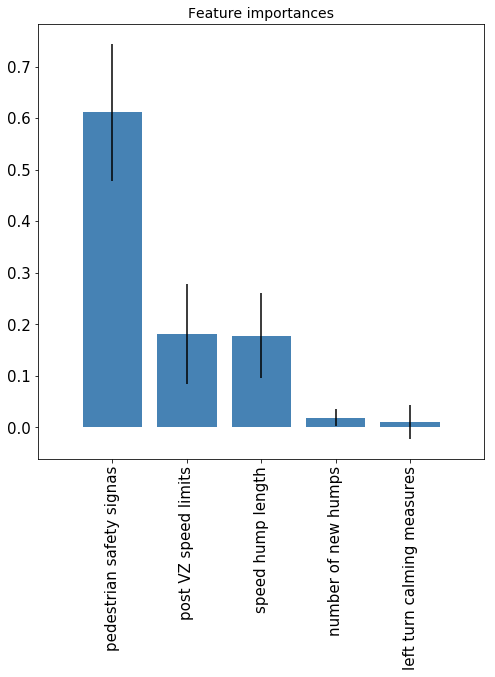

In [178]:
featureImportancePlot(rf,features)

### Figure Interpretation:
The above figure shows how important the features are when it comes to predicting the number of collisions on the given street conditions. The random forest regression tree has an r-squared value about 0.35, which means it can explain about 35% of the variance. This graph is therefore a confirmation that existing street conditions are a reliable indicator of the collision conditions. 

Future work involves unearthing more other street conditions and developing a classifier to identify what type of accidents a particular street is more prone to

In [107]:
rf_param2 = df[['peds_safety_sig', 'postvz_sl']]
rf_pred2 = df[['incidents']]
rf_param_train , rf_param_test , rf_pred_train,rf_pred_test = train_test_split(np.array(rf_param2) , np.array(rf_pred2) , random_state =1,test_size=0.8)
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(rf_param_train, rf_pred_train)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [108]:
rf_prediction = rf.predict(rf_param_test)
errors = abs(rf_prediction.reshape(rf_prediction.shape[0],1) - rf_pred_test)
rf.score(rf_param_test, rf_pred_test)

0.37150651846643856

In [109]:
sf_df.head()

,street_name,NUMBER OF PERSONS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,peds_safety_sig,postvz_sl,shape_leng,new_humps,lt_calm,incidents
0,NaN,8.0,0,0.0,3,1,0,4,0,0.0,0.0,333.938333,0.0,0.0,8.0
1,1 278 robert f kennedy bridge n/,0.0,0,0.0,0,0,0,0,0,0.0,0.0,333.938333,0.0,0.0,0.0
2,1 900 g robert f kennedy bridge,0.0,0,0.0,0,0,0,0,0,0.0,0.0,333.938333,0.0,0.0,0.0
3,1 ave,0.0,0,0.0,0,0,0,0,0,0.0,0.0,333.938333,0.0,0.0,0.0
4,1 avenue,944.0,2,3.0,271,188,1,486,0,79.0,25.0,163.472673,0.0,0.0,947.0


In [114]:
sf_df['ped_c'] = sf_df['NUMBER OF PEDESTRIANS INJURED'] + sf_df['NUMBER OF PEDESTRIANS KILLED']
sf_df['mot_c'] = sf_df['NUMBER OF MOTORIST INJURED'] + sf_df['NUMBER OF MOTORIST KILLED']
sf_df['cyc_c'] = sf_df['NUMBER OF CYCLIST INJURED'] + sf_df['NUMBER OF CYCLIST KILLED']


In [115]:
cl_df = sf_df[['ped_c','mot_c','cyc_c','peds_safety_sig', 'postvz_sl','shape_leng','new_humps','lt_calm']]

In [ ]:
weather_data['hour'].apply(lambda x: 3 if x >=3 and x<=6 else ( 7 if x >=7 and x<=10 else( 11 if x>=11 and x<=14 else ( 15 if x>=15 and x<=18 else ( 19 if x>=19 and x<=22 else 23)))))

In [140]:
cl_df['max_c'] = cl_df.apply(lambda row: 'motor' if row['mot_c'] >= row['cyc_c'] and row['mot_c'] > row['ped_c'] else ('cycle' if row['cyc_c'] > row['mot_c'] and row['cyc_c'] > row['ped_c'] else ('peds' if row['ped_c'] > row['mot_c'] and row['ped_c'] > row['cyc_c'] else ('noone' if row['ped_c']==0 and row['mot_c']==0 and row['cyc_c']==0 else 'motor'))), axis = 1)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [ ]:
 if row['cyc_c'] >= row['mot_c'] and row['cyc_c'] >= row['ped_c']
    else ('pedestrian' if row['ped_c'] >= row['mot_c'] and row['ped_c'] >= row['cyc_c'] )

In [141]:
cl_df.head(25)

,ped_c,mot_c,cyc_c,peds_safety_sig,postvz_sl,shape_leng,new_humps,lt_calm,max_c
0,3,4,1,0.0,0.000000,333.938333,0.0,0.0,motor
1,0,0,0,0.0,0.000000,333.938333,0.0,0.0,noone
2,0,0,0,0.0,0.000000,333.938333,0.0,0.0,noone
3,0,0,0,0.0,0.000000,333.938333,0.0,0.0,noone
4,273,486,189,79.0,25.000000,163.472673,0.0,0.0,motor
5,0,0,0,0.0,0.000000,333.938333,0.0,0.0,noone
6,0,0,0,0.0,0.000000,333.938333,0.0,0.0,noone
7,0,2,0,0.0,25.000000,389.038179,0.0,0.0,motor
8,0,0,0,0.0,0.000000,333.938333,0.0,0.0,noone
9,0,1,1,0.0,25.000000,303.938503,4.0,0.0,motor


In [150]:
cl_df.to_csv('./sfc.csv')

In [143]:
cl_features = cl_df[['peds_safety_sig', 'postvz_sl',
       'shape_leng', 'new_humps', 'lt_calm']]
cl_classify = cl_df[['max_c']]
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

model.fit(cl_features, cl_classify)
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = cl_features.columns,
                class_names = cl_classify.values,
                rounded = True, proportion = False, 
                 filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [180]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
X_train, X_test, y_train, y_test = train_test_split(cl_features,cl_classify, test_size=0.30, random_state=42)
nb.fit(X_train, y_train)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [181]:
y_pred = nb.predict(X_test)

In [182]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.629193433262


In [183]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

[[  0  26  23   0]
 [  0 947 328   4]
 [  0 399 816   0]
 [  0 178  81   0]]


[[947 328   4   0]
 [399 816   0   0]
 [178  81   0   0]
 [ 26  23   0   0]]


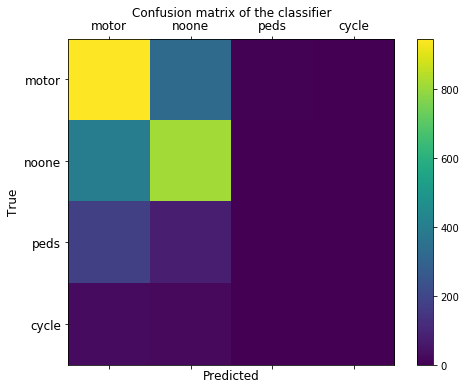

In [192]:
labels = ['motor', 'noone', 'peds', 'cycle']
cm = confusion_matrix(y_test, y_pred, labels)
print(cm)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels, fontsize=12.0)
ax.set_yticklabels([''] + labels, fontsize=12.0)
plt.xlabel('Predicted', fontsize=12.0)
plt.ylabel('True', fontsize=12.0)
plt.show()
pl.savefig('cm1.png')

### Figure Interpretation:

Due to skew in the dataset, the multinomial naive bayes classifer seems to predict the motor and non accidents more accurately than the ones where pedestrians and cyclists are involved. 